# Preparation

In [1]:
import sys
import os
import warnings
import pickle

import numpy as np
import xarray as xr
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib
import cartopy
import cartopy.crs as ccrs
import pop_tools
import cmocean
import gsw
from mpl_toolkits.axes_grid1 import ImageGrid
import cftime
sys.path.insert(0, "/home/dpfluger/scripts/cesm_tools/")
import cesm_data_tools
import pop_plot
import cesm_scenarios
import geo_tools
#import msf_tools

plt.style.use('seaborn')
matplotlib.rcParams['font.family'] = 'Nimbus Roman'
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2
# reset to standard notebook plotting after enabling animated plots
%matplotlib inline 

## Data

In [2]:
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01',
                                                        'years': np.arange(2015,2100)
                                                       }}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02','years': np.arange(2045,2100)} }
cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.05',
                                                        'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.06',
                                                        'years': np.arange(2086,2100)}
}
cases_sai80j = {'b.e21.BSSP585cmip6.f09_g17.feedback.09': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09',
                                                        'years': np.arange(2080,2100)},
}

cases = [cases_cnt, cases_sai20, cases_sai80, cases_sai80j]

scenario_names = ['Control', 'SAI 2020', 'SAI 2080', 'SAI 2080 J']

scenarios = {name: cesm_scenarios.Scenario(name,case) for name, case in zip(scenario_names,cases)}

In [3]:
get_ocn_vars = ['SALT', 'TEMP', 'RHO', 
                'SHF', 'HMXL',
                'EVAP_F', 'PREC_F', 'SALT_F', 'SFWF', 'ROFF_F', 'MELT_F', 
                'IOFF_F', 'MELT_F','MOC', 'N_HEAT']


get_ice_vars = ['fresh', 'fsalt']

get_atm_vars = ['TREFHT', 'FSNT', 'FLNT']

for var in get_ocn_vars:
    for name in scenarios:
        scenarios[name].get_ocn_var(var)

for var in get_ice_vars:
    for name in scenarios:
        scenarios[name].get_ice_var(var)

for var in get_atm_vars:
    for name in scenarios:
        scenarios[name].get_atm_var(var)

In [4]:
# load data
ssp_labels = ['ssp126','ssp245','ssp370','ssp585']
amoc_cmip = {}

cmip_data_path = '/home/dpfluger/analysis/amoc'

for name in ssp_labels:

    da_1 = xr.concat([xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r4i1p1f1_gn_201501-206412.nc'),
        xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r4i1p1f1_gn_206501-210012.nc')],dim='time')
    da_2 = xr.concat([xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r10i1p1f1_gn_201501-206412.nc'),
        xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r10i1p1f1_gn_206501-210012.nc')],dim='time')
    da_3 = xr.concat([xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r11i1p1f1_gn_201501-206412.nc'),
        xr.open_dataset(f'{cmip_data_path}/cmip6/msftmz_Omon_CESM2_{name}_r11i1p1f1_gn_206501-210012.nc')],dim='time')
    
    amoc_cmip[name] = xr.concat([da_1.msftmz,da_2.msftmz,da_3.msftmz],pd.Index([0,1,2],name='ens'))
    

In [5]:
def concat_sai2080(var_name,ts=slice('2070','2079'),sai80_name='SAI 2080'):
    da_concat = xr.concat([scenarios['Control'][var_name].sel(time=ts),
                           scenarios[sai80_name][var_name]],dim='time')
    return da_concat

for var in ['TREFHT','MOC','N_HEAT']:
    scenarios['SAI 2080'].var[var] = concat_sai2080(var)

In [6]:
pop_ds = xr.open_dataset('/home/dpfluger/links/leo_archive/b.e21.BSSP585cmip6.f09_g17.control.01/ocn/hist/b.e21.BSSP585cmip6.f09_g17.control.01.pop.h.2021-01.nc')
tarea = pop_ds.TAREA * 10**(-4)
dz = pop_ds.dz * 10**(-2)

In [7]:
ss_data_path = './data'

for var_name in ['sst','sst_east','sst_west']:
    for name in scenarios:
        da = xr.open_dataset(f'{ss_data_path}/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        scenarios[name].var[var_name] = da
        
for var_name in ['sss','sss_east','sss_west']:
    for name in scenarios:
        da = xr.open_dataset(f'{ss_data_path}/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        scenarios[name].var[var_name] = da

## Utilities

In [8]:
def ocean_heat_content(da,tarea=tarea,dz=dz):
    
    '''
    To-Do: check z integration: what scheme does xarray use? do we have the right spatial coordinate?
    note that z is the distance from surface to the _mid_layer depth
    
    units of tarea: m^2 and dz: m
    '''
    
    rho = 1025 # kg m^-3
    C = 3985 # J kg^-1 K^-1
    
    phi = rho * C * (tarea * (dz * da).sum(dim='z_t')).sum(['nlat','nlon']) 
    
    return phi

def ocean_heat_map(da,dz=dz):
    
    '''
    Compute OHC anomaly in every grid cell separately
    This means that the nlat,nlon summation step is not performed in comparison with ocean_heat_content
    
    Output in units J / m^2 (ocean heat stored in a water column)
    '''
    
    rho = 1025 # kg m^-3
    C = 3985 # J kg^-1 K^-1
    
    phi = rho * C * ((dz * da).sum(dim='z_t'))
    
    return phi

def ocean_heat_layers(da,tarea=tarea,dz=dz):
    '''
    Compute OHC anomaly in every separate layer
    This means that the z summation is not carried out
    
    Output in units J (ocean heat stored in given layer)
    '''
    
    rho = 1025 # kg m^-3
    C = 3985 # J kg^-1 K^-1
    
    phi = rho * C * (dz * (da*tarea).sum(dim=['nlat','nlon']))
    
    return phi

def max_ohc_depth_map(da,
                      tarea=tarea,
                      dz=dz,
                      ts_ref=slice('2020','2029'),
                      ts_test=slice('2090','2099')):
    '''
    Map out at which level at every grid point there is a maximum increase in OHC. E.g., a value of
    1000m at a fixed location would mean that the maximum change in OHC happens at that particular depth.
    '''
    
    
    # 3D heat content computation
    # Note that taking an average over time helps avoid too strong noise
    # Multiplication with grid cell sizes is saved for later
    # Note that taking the maximum is independent of the positive scaling factor rho * c
    # It can therefore be omitted entirely
    phi_ref  = da.sel(time=ts_ref).mean(dim='time')
    phi_test = da.sel(time=ts_test).mean(dim='time')
    
    phi_diff = (phi_test - phi_ref) * dz * tarea
    phi_diff = phi_diff.fillna(0) # Avoid all-NaN values (in land regions)
    depth_of_max_diff = phi_diff.idxmax(dim='z_t') # returns the z-_position_ of the maximum 
    
    return depth_of_max_diff



In [9]:
def moc_max(da,lat=26,min_depth=None,comps=slice(None,None)):
    '''
    Evaluate AMOC maximum at fixed latitude (in deg N) below certain depth (in m)
    
    Note: sum over MOC components (advective & eddies): this is the format of the CMIP6 variables
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(transport_reg=1)
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat_aux_grid=lat,method='nearest') \
        .sel(moc_z=slice(min_depth,None))
    
    # sum over components
    da_amoc = da_amoc.sel(moc_comp=comps)
    da_amoc = da_amoc.sum(dim='moc_comp')

    return da_amoc.max(dim='moc_z')

def moc_max_lat_interval(da,lat=slice(0,90),min_depth=None,comps=slice(None,None)):
    '''
    Evaluate AMOC maximum over latitude interval below certain depth (in m)
    
    Note: sum over MOC components (advective & eddies): this is the format of the CMIP6 variables
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(transport_reg=1)
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat_aux_grid=lat) \
        .sel(moc_z=slice(min_depth,None))
    
    # sum over components
    da_amoc = da_amoc.sel(moc_comp=comps)
    da_amoc = da_amoc.sum(dim='moc_comp')

    return da_amoc.max(dim=['moc_z','lat_aux_grid'])


def moc_argmax_lat_interval(da,lat=slice(0,90),min_depth=None,comps=slice(None,None)):
    '''
    Evaluate AMOC maximum over latitude interval below certain depth (in m)
    
    Note: sum over MOC components (advective & eddies): this is the format of the CMIP6 variables
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(transport_reg=1)
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat_aux_grid=lat) \
        .sel(moc_z=slice(min_depth,None))
    
    # sum over components
    da_amoc = da_amoc.sel(moc_comp=comps)
    da_amoc = da_amoc.sum(dim='moc_comp')

    return da_amoc.argmax(dim=['moc_z','lat_aux_grid'])

def mht_max(da,lat=slice(0,None)):
    '''
    Evaluate maximum MHT for AMOC in given latitude range (default is northern hemisphere)
    '''
    da_amoc = da.isel(transport_reg=1,transport_comp=1)
    da_amoc = da_amoc.sel(lat_aux_grid=lat)
    return da_amoc.max(dim='lat_aux_grid')

def mht_argmax(da,lat=slice(0,None)):
    '''
    Evaluate maximum MHT for AMOC in given latitude range (default is northern hemisphere)
    '''
    da_amoc = da.isel(transport_reg=1,transport_comp=1)
    da_amoc = da_amoc.sel(lat_aux_grid=lat)
    return da_amoc.argmax(dim='lat_aux_grid')

def mht(da,lat=26):
    '''
    Evaluate MHT for AMOC at fixed latitude (in deg N)
    '''
    da_amoc = da.isel(transport_reg=1,transport_comp=1)
    da_amoc = da_amoc.sel(lat_aux_grid=lat,method='nearest')
    return da_amoc

def moc_max_cmip(da,lat=26,min_depth=None,rho_ref=1030):
    '''
    Evaluate AMOC maximum for mean velocity field stream function
    at fixed latitude (in deg N) below certain depth (in m) (using CMIP6 data)
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(basin=0)
        
    # convert to volumetric AMOC rather mass AMOC
    # units of sv
    da_amoc = da_amoc/(rho_ref * 10**6)
    
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat=lat,method='nearest') \
        .sel(lev=slice(min_depth,None))

    return da_amoc.max(dim='lev')


def moc_max_lat_interval_cmip(da,lat=slice(0,90),min_depth=None,rho_ref=1030):
    '''
    Evaluate AMOC maximum for mean velocity field stream function
    at fixed latitude (in deg N) below certain depth (in m) (using CMIP6 data)
    '''
    if min_depth:
        min_depth = min_depth * 100 # unit conversion: m -> cm
        
    # select amoc
    da_amoc = da.isel(basin=0)
        
    # convert to volumetric AMOC rather mass AMOC
    # units of sv
    da_amoc = da_amoc/(rho_ref * 10**6)
    
    # select latitude and depth
    da_amoc = \
        da_amoc.sel(lat=lat) \
        .sel(lev=slice(min_depth,None))

    return da_amoc.max(dim=['lev','lat'])

In [10]:
grid_name = 'POP_gx1v7'
pop_regions = pop_tools.get_grid(grid_name)

# Global mask
pop_ds = xr.open_dataset('/home/dpfluger/links/leo_archive/b.e21.BSSP585cmip6.f09_g17.control.01/ocn/hist/b.e21.BSSP585cmip6.f09_g17.control.01.pop.h.2021-01.nc')
tarea_global = pop_ds.TAREA * 10**(-4)
tarea_global = tarea_global.where((pop_regions.REGION_MASK != 0)).fillna(0)
dz = pop_ds.dz * 10**(-2)

# Atlantic/Arctic sea regions
# 'Atlantic Ocean', 'Lab. Sea & Baffin Bay', 
# 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'
#region_ids = [7,9,10,11,12]
region_ids = [7, 9]
pop_regions.region_name.isel(nreg=region_ids)
region_vals = pop_regions.region_val.sel(nreg=region_ids)

# select Atlantic and Polar seas
ones = xr.ones_like(pop_regions.REGION_MASK)
mask = xr.zeros_like(pop_regions.REGION_MASK)
for r_id in region_vals:
    mask_partial = ones.where(pop_regions.REGION_MASK==r_id)
    mask_partial = mask_partial.fillna(0)
    mask = mask + mask_partial
# Focus on Northern Atlantic
mask = mask.where((pop_regions.TLAT>45) & (pop_regions.TLAT<65) & (pop_regions.TLONG>280)).fillna(0)

tarea_mask_na = tarea_global * mask

In [11]:
# Use APRIL as reference month
month_i = 4 # April: 4th month
mx_month = scenarios['Control'].var['HMXL'].sel(time=slice('2015','2030')).groupby('time.month')[month_i]
mx_month = mx_month.mean(dim='time')

cut_off_depth = 55000
dwf_regions = (mx_month>cut_off_depth).compute() # GLOBAL!
tarea_dwf = tarea_mask_na.where(dwf_regions>0).fillna(0).compute() # Narrow selection down to North Atlantic

dwf_west = dwf_regions.where(dwf_regions.TLONG<318).fillna(0)
dwf_east = dwf_regions.where(dwf_regions.TLONG>320).fillna(0) # this cuts of an overlapping point

tarea_dwf_west = tarea_dwf.where(dwf_west>0).fillna(0)
tarea_dwf_east = tarea_dwf.where(dwf_east>0).fillna(0)

# redefine tarea_dwf such that the overlapping point is omitted
tarea_dwf = tarea_dwf_west + tarea_dwf_east
dwf_regions = dwf_west + dwf_east

In [12]:
def dwf_mean(da,mask_roi=tarea_dwf):
    
    weighted_sum = (da * mask_roi).sum(dim=['nlat','nlon'])
    norm = mask_roi.sum()
    
    return weighted_sum/norm

def dwf_int(da,mask_roi=tarea_dwf):
    '''
    units:
    [mask_area] m^2
    [output]: da * m^2 
    
    '''

    weighted_sum = (da * mask_roi).sum(dim=['nlat','nlon'])
    
    return weighted_sum

def dwf_max(da,bin_mask_roi=dwf_regions):
    
    masked_da = da * bin_mask_roi
    return masked_da.max(dim=['nlat','nlon'])

def dwf_vol(da,mask_roi=tarea_dwf):
    
    ml_vol = (da * mask_roi).sum(dim=['nlat','nlon'])
    # when skipping the normalization step, we obtain a mixed layer volume
    # rather than an avg ml depth
    # mixed layer volume = sum of mixed layer depths * grid cell are over all grid cells
    
    return ml_vol

def thermal_sdf(scenario):
    '''
    Thermal contribution to thermal surface density flux
    
    Parameters:
    shf (xr.DataArray): surface heat flux
    '''
    
    sst = scenario.var['TEMP'].isel(z_t=0)
    sss = scenario.var['SALT'].isel(z_t=0) 
    shf = scenario.var['SHF']
    
    cp = gsw.cp_t_exact(sss,sst,0)
    alpha = gsw.alpha_wrt_t_exact(sss,sst,0)
    
    tsdf = - alpha * shf/cp
    
    return tsdf

def haline_sdf(scenario):
    '''
    Thermal contribution to thermal surface density flux
    
    Parameters:
    scenario (Scenario)
    '''
    
    sss = scenario.var['SALT'].isel(z_t=0) # sea surface salinity, g/kg
    sst = scenario.var['TEMP'].isel(z_t=0) # surface pot temp, deg C
    #rho_fresh = gsw.rho_t_exact(0,sst,0) # density of sea surface assuming no salinity 
    
    beta = gsw.beta_const_t_exact(sss,sst,0)
    
    # Freshwater flux
    #evap = scenario.var['EVAP_F'] # negative values
    #prec = scenario.var['PREC_F'] # positive values
    
    sfwf = scenario.var['SFWF'] # N Howe et al, 2009, J Phys Ocean
    
    # Haline SDF
    # hsdf = - rho_fresh * beta * (sfwf * sss)/(1-sss)
    #hsdf = - beta * (sfwf * sss)/(1-sss)
    hsdf = - beta * sfwf * sss
    
    return hsdf

def atm_fw(scenario):
    '''
    Compute atmospheric freshwater flux (precipitation - evaporation)
    Positive values: freshwater flux into ocean
    '''
    # Freshwater flux
    evap = scenario.var['EVAP_F'] # negative values
    prec = scenario.var['PREC_F'] # positive values
    
    # 
    sfwf = prec + evap
    
    return sfwf

def ice_fw(scenario):
    
    # Ice
    sss = scenario.var['SALT'].isel(z_t=0)
    rho = scenario.var['RHO'].isel(z_t=0)
    salt_f = scenario.var['SALT_F']
    
    ice_term = salt_f * sss * rho
    
    return ice_term

def atm_ice_fw(scenario):
    '''
    Compute freshwater flux including ice contribution
    '''
    atm_term = atm_fw(scenario) 
    ice_term = ice_fw(scenario)
    
    total_fw = atm_term + ice_term
    
    return total_fw 
    
def march_ml_depth(scenario):
    
    ml_march = scenario.var['HMXL'].groupby('time.month')[3]
    
    return ml_march

def max_march_ml_depth(scenario):
    
    ml_march = march_ml_depth(scenario)
    max_ml_march = ml_march.max(dim=['nlat','nlon'])
    
    return max_ml_march

def month_ml_depth(scenario,month_i=month_i):
    
    ml_month = scenario.var['HMXL'].groupby('time.month')[month_i]
    return ml_month

def max_month_ml_depth(scenario,month_i=month_i):
    
    ml_month = month_ml_depth(scenario,month_i)
    max_ml_month = ml_month.max(dim=['nlat','nlon'])
    
    return max_ml_month
    
def get_sst(scenario):
    
    sst = scenario.var['TEMP'].isel(z_t=0)
    
    return sst

def get_sss(scenario):
    
    sss = scenario.var['SALT'].isel(z_t=0)
    
    return sss

# Means, plotting etc.

def global_ocn_mean(scenario,func,mask=tarea_global):
    
    weighted_sum = (func(scenario) * mask).sum(['nlat','nlon'])

def masked_ocn_mean(scenario,func,mask=tarea_mask_na):
    
    weighted_sum = (func(scenario) * mask).sum(['nlat','nlon'])
    norm = mask.sum(['nlat','nlon'])
    
    return weighted_sum/norm

def apply_on_scenarios(scenarios,func):
    
    result_dict = {}
    for name in scenarios:
        print(name)
        result_dict[name] = func(scenarios[name]).compute()
        
    return result_dict

def annual_mean_on_scenarios(in_dict):
    result_dict = {}
    for name in in_dict:
        result_dict[name] = in_dict[name].groupby('time.year').mean(dim='time').compute()
    return result_dict

def dwf_mean_z(da, mask_roi = tarea_dwf):
    if 'time' in da.dims:
        da_ss = da.isel(time=0) # 'snapshot' of input data (eliminates time dim)
    else:
        da_ss = da
    z_mask = xr.ones_like(da_ss).where(np.isfinite(da_ss)) * mask_roi
    
    weighted_sum = (da * z_mask).sum(dim=['nlat','nlon'])
    norm = z_mask.sum(dim=['nlat','nlon'])
    
    return weighted_sum/norm

def strat_index(scenario,**kwargs):
    '''
    Reference depth z_test in m
    Computes density difference between top and reference layer for region of interest
    '''
    return top_minus_ref(scenario['RHO'],**kwargs)

def top_minus_ref(da,z_test=200,mask_roi=tarea_dwf):
    '''
    This is much faster thanks to the pre-selection! -> ~ factor six performance increase
    '''
    
    # do preselection based on mask_roi
    bool_mask = tarea_dwf > 0
    da_sel = da.where(bool_mask,drop=True)
    mask_roi_sel = mask_roi.where(bool_mask,drop=True)
    
    two_layers = da_sel.sel(z_t=(0,z_test*100),method='nearest')
    diff = dwf_mean_z(two_layers.diff(dim='z_t'),mask_roi=mask_roi_sel)
    
    return diff.isel(z_t=0)

# AOD & GMST

In [115]:
strataero_paths = {
    'SAI 2020': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_CAMfeedback-2100.nc',
    'SAI 2080': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.06/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_CAMfeedback.nc',
    'SAI 2080 J': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_CAMfeedback.nc'
}

In [116]:
aod = {}
for name in strataero_paths:
    aod[name] = xr.open_dataset(strataero_paths[name]).AODVISstdn

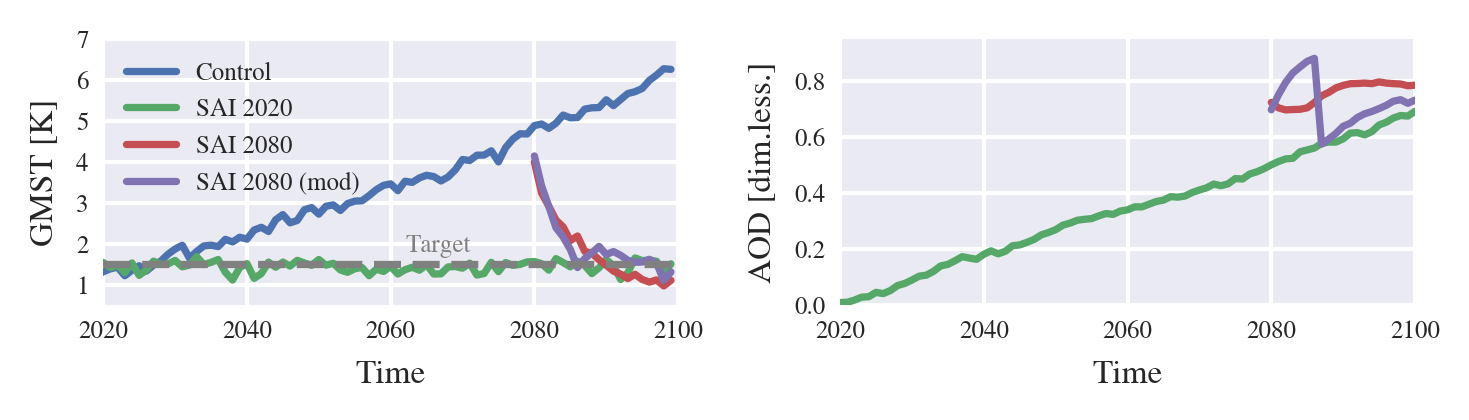

In [120]:
fig, axes = plt.subplots(ncols=2,figsize=(5,1.5),dpi=300)
fsize, fsize_min = 8, 6

T_ref = 288.73-1.5 
T_target = T_ref+1.5 

for name in scenarios:
    gmst = scenarios[name]['TREFHT'].geo.sfc_mean().groupby('time.year').mean(dim='time')
    gmst = gmst - T_ref
    if name == 'SAI 2080':
        gmst = gmst.sel(year=slice('2080','2100'))
    if name == 'SAI 2080 J':
        lname = 'SAI 2080 (mod)'
    else:
        lname = name
    gmst.plot(label=lname,ax=axes[0])
axes[0].axhline(y=1.5,linestyle='dashed',color='grey')
    
colors = ['C1','C2','C3']
for name,color in zip(strataero_paths,colors):
    aod_ann = aod[name].geo.sfc_mean().groupby('time.year').mean(dim='time') 
    if name in ['SAI 2080', 'SAI 2080 J']:
        aod_ann = aod_ann.sel(year=slice('2080','2100'))
    if name == 'SAI 2080 J':
        lname = 'SAI 2080 (mod)'
    else:
        lname = name
    aod_ann.sel(year=slice('2020','2100')).plot(label=lname,ax=axes[1],color=color)
    
axes[0].legend(fontsize=fsize_min)

for ax in axes:
    ax.set_xlim([2020,2100])
    ax.set_xlabel('Time',fontsize=fsize)
    ax.tick_params(axis='both',labelsize=fsize_min,pad=3.5)

axes[0].set_ylim([0.5,6.5])
axes[0].set_ylabel('GMST [K]',fontsize=fsize)
axes[0].set_yticks([1,2,3,4,5,6,7])
axes[0].text(2062,1.8,'Target',fontsize=fsize_min,color='grey')

axes[1].set_ylim([0,0.95])
axes[1].set_ylabel('AOD [dim.less.]',fontsize=fsize)

plt.tight_layout()

In [121]:
fig.savefig('./gfx/sfig_aod_gmst.pdf',bbox_inches='tight')

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


# Surface forcing

In [13]:
sfwf_dict = {
    name: dwf_mean(scenarios[name]['SFWF']).groupby('time.year').mean(dim='time').compute() for name in scenarios
}

prec_dict = {
    name: dwf_mean(scenarios[name]['PREC_F']).groupby('time.year').mean(dim='time').compute() for name in scenarios
}

evap_dict = {
    name: dwf_mean(scenarios[name]['EVAP_F']).groupby('time.year').mean(dim='time').compute() for name in scenarios
}

atm_fw_dict = {
    name: prec_dict[name] + evap_dict[name] for name in scenarios
}

res_dict = {
    name: sfwf_dict[name] - atm_fw_dict[name] for name in scenarios
}

saltf_dict = {
    name: dwf_mean(scenarios[name]['SALT_F']).groupby('time.year').mean(dim='time').compute() for name in scenarios
}

meltf_dict = {
    name: dwf_mean(scenarios[name]['MELT_F']).groupby('time.year').mean(dim='time').compute() for name in scenarios
}

iofff_dict = {
    name: dwf_mean(scenarios[name]['IOFF_F']).groupby('time.year').mean(dim='time').compute() for name in scenarios
}

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


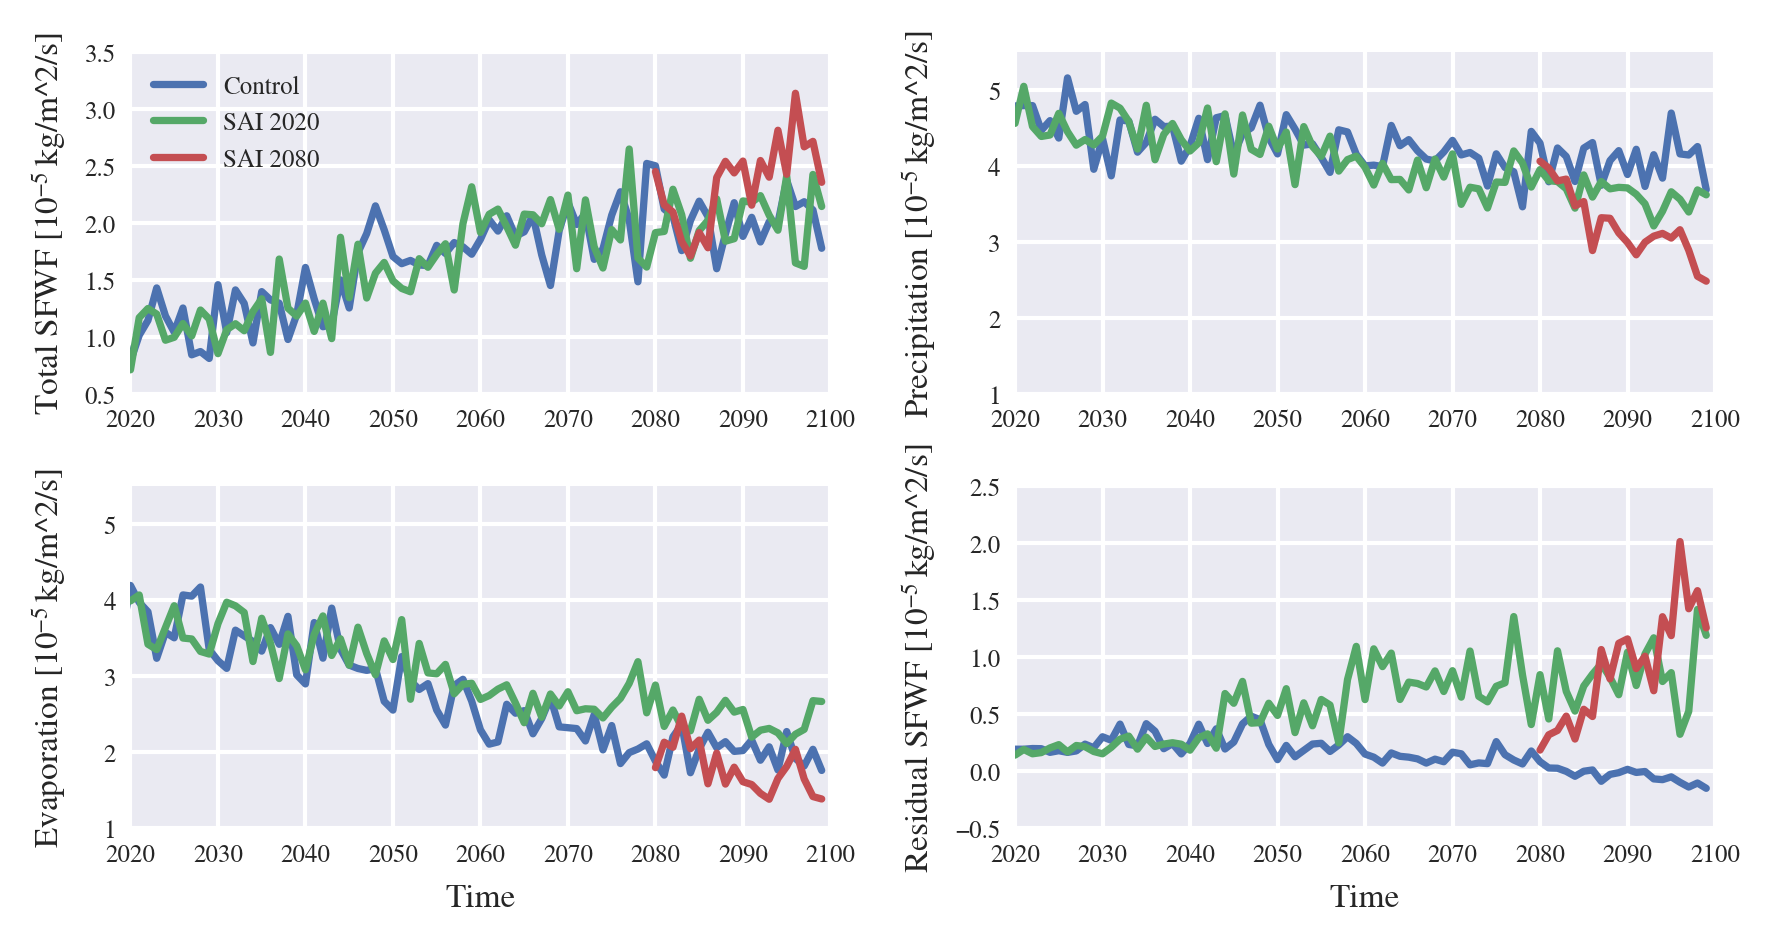

In [16]:
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(6.0,3.2),dpi=300)
fsize,fsize_min = 8, 6
scenarios_select = ['Control','SAI 2020','SAI 2080']

# Total SFWF

for name in scenarios_select:
    (sfwf_dict[name]*1e5).plot(label=name,ax=axes[0,0])
    (prec_dict[name]*1e5).plot(label=name,ax=axes[0,1])
    (-evap_dict[name]*1e5).plot(label=name,ax=axes[1,0])
    (res_dict[name]*1e5).plot(label=name,ax=axes[1,1])
    #atm_fw_dict[name].plot(ax=axes[1])

for axes_row in axes:
    for ax in axes_row:
        ax.set_xlim([2020,2100])
        ax.tick_params(axis='both',labelsize=fsize_min,pad=3.5)
        ax.set_xlabel('Time',fontsize=fsize)

axes[0,0].set_ylim([0.5,3.5])
axes[0,1].set_ylim([1.0,5.5])
axes[1,0].set_ylim([1.0,5.5])
axes[1,1].set_ylim([-0.5,2.5])

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,0].legend(fontsize=fsize_min)
axes[0, 0].set_ylabel(r'Total SFWF [$\mathregular{10^{-5}}\,$kg/m^2/s]',fontsize=fsize)
axes[0, 1].set_ylabel(r'Precipitation [$\mathregular{10^{-5}}\,$kg/m^2/s]',fontsize=fsize)
axes[1, 0].set_ylabel(r'Evaporation [$\mathregular{10^{-5}}\,$kg/m^2/s]',fontsize=fsize)
axes[1, 1].set_ylabel(r'Residual SFWF [$\mathregular{10^{-5}}\,$kg/m^2/s]',fontsize=fsize)

#axes[1].set_ylabel('Atm SFWF [kg/m^2/s]')

fig.tight_layout()
fig.align_ylabels(axes[:, 0])
fig.align_ylabels(axes[:, 1])
fig.savefig('./gfx/sfig_sfwf.pdf',bbox_inches='tight')

# Mixed Layer Depth vs Surface Density

In [73]:
path = '../../ocean_convection/data/'
for name in scenarios:
    for rname in ['_east','_west','']:
        ml = xr.open_dataset(path+f'ml{rname}_{name}.nc').__xarray_dataarray_variable__
        strat = xr.open_dataset(path+f'strat{rname}_{name}.nc').__xarray_dataarray_variable__

        scenarios[name].var[f'ml{rname}'] = ml
        scenarios[name].var[f'strat{rname}'] = strat
        
rho_sfc, rho_sfc_east, rho_sfc_west = {}, {}, {} # deprecated
for var_name, var_dict in zip(['rho_sfc','rho_sfc_east','rho_sfc_west'],[rho_sfc,rho_sfc_east,rho_sfc_west]):
    for name in scenarios:
        da = xr.open_dataset(f'../../ocean_convection/data/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        scenarios[name].var[var_name] = da

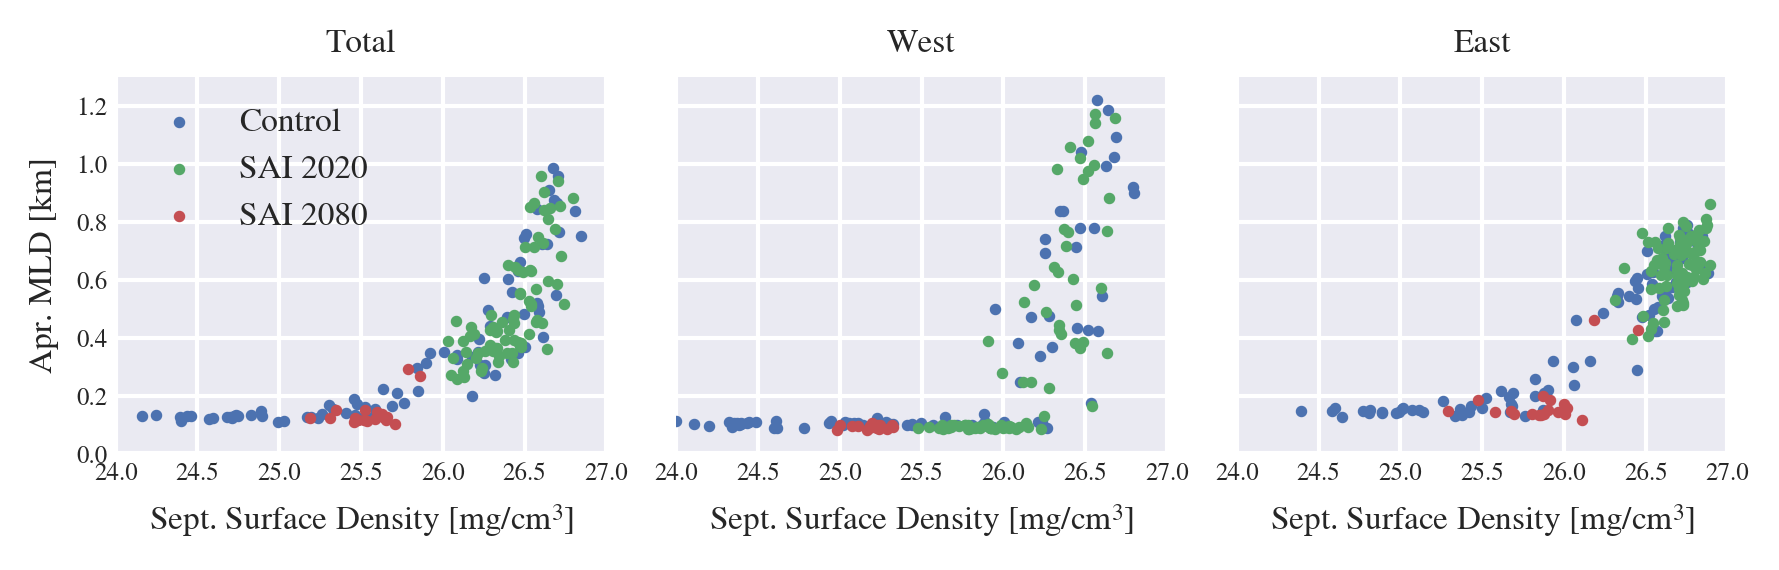

In [90]:
fsize, fsize_min = 8, 6

fig, axes = plt.subplots(ncols=3,figsize=(6,2),dpi=300)

scenarios_select = ['Control', 'SAI 2020', 'SAI 2080']
for name in scenarios_select:
    for ax, rsuffix, rname in zip(axes,['','_west','_east'], ['Total','West','East']):
        ml = scenarios[name].var[f'ml{rsuffix}'][1:]
        strat = scenarios[name].var[f'rho_sfc{rsuffix}'][0:-1]
        ax.scatter((strat-1)*1000,ml/(100*1000),s=6,label=name)
        ax.set_title(rname,fontsize=fsize)
axes[0].legend(fontsize=fsize)
        
for ax in axes:
    #ax.set_xlim([1,4])
    #ax.set_ylim([0,1.3])
    ax.set_xlabel(r'Sept. Surface Density [mg/$\mathregular{cm^3}$]',fontsize=fsize)
    ax.set_ylabel('Apr. MLD [km]',fontsize=fsize)
    #ax.set_yticks(np.arange(0,1.4,0.2))
    #ax.set_xticks(np.arange(1,4.5,0.5))
    ax.set_xlim([24,27])
    ax.tick_params(which='both',labelsize=fsize_min,pad=2.0)
    ax.set_ylim([0,1.3])
    
for ax in axes[1:3]:
    ax.set_ylabel(None)
    ax.set_yticklabels([])
    
#axes[0].set_xlim([1.5,7.5])
#axes[1].set_xlim([1.5,7.0])
#axes[2].set_xlim([1.3,7.1])
    
plt.tight_layout()

In [91]:
fig.savefig('./gfx/sfig_mld_vs_rho.pdf')

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


# SSS/SST Trajectories

In [92]:
path = '../../ocean_convection/data/'
for name in scenarios:
    for rname in ['_east','_west','']:
        ml = xr.open_dataset(path+f'ml{rname}_{name}.nc').__xarray_dataarray_variable__
        strat = xr.open_dataset(path+f'strat{rname}_{name}.nc').__xarray_dataarray_variable__
        sfc_rho = xr.open_dataset(path+f'rho_sfc{rname}_{name}.nc').__xarray_dataarray_variable__
        scenarios[name].var[f'ml{rname}'] = ml
        scenarios[name].var[f'strat{rname}'] = strat
        scenarios[name].var[f'rho_sfc{rname}'] = sfc_rho
        
def sel_month(da,month_i):
    ts = da.time
    return da.where(da.time.dt.month==month_i).dropna(dim='time')

In [93]:
from matplotlib.ticker import LinearLocator, MultipleLocator

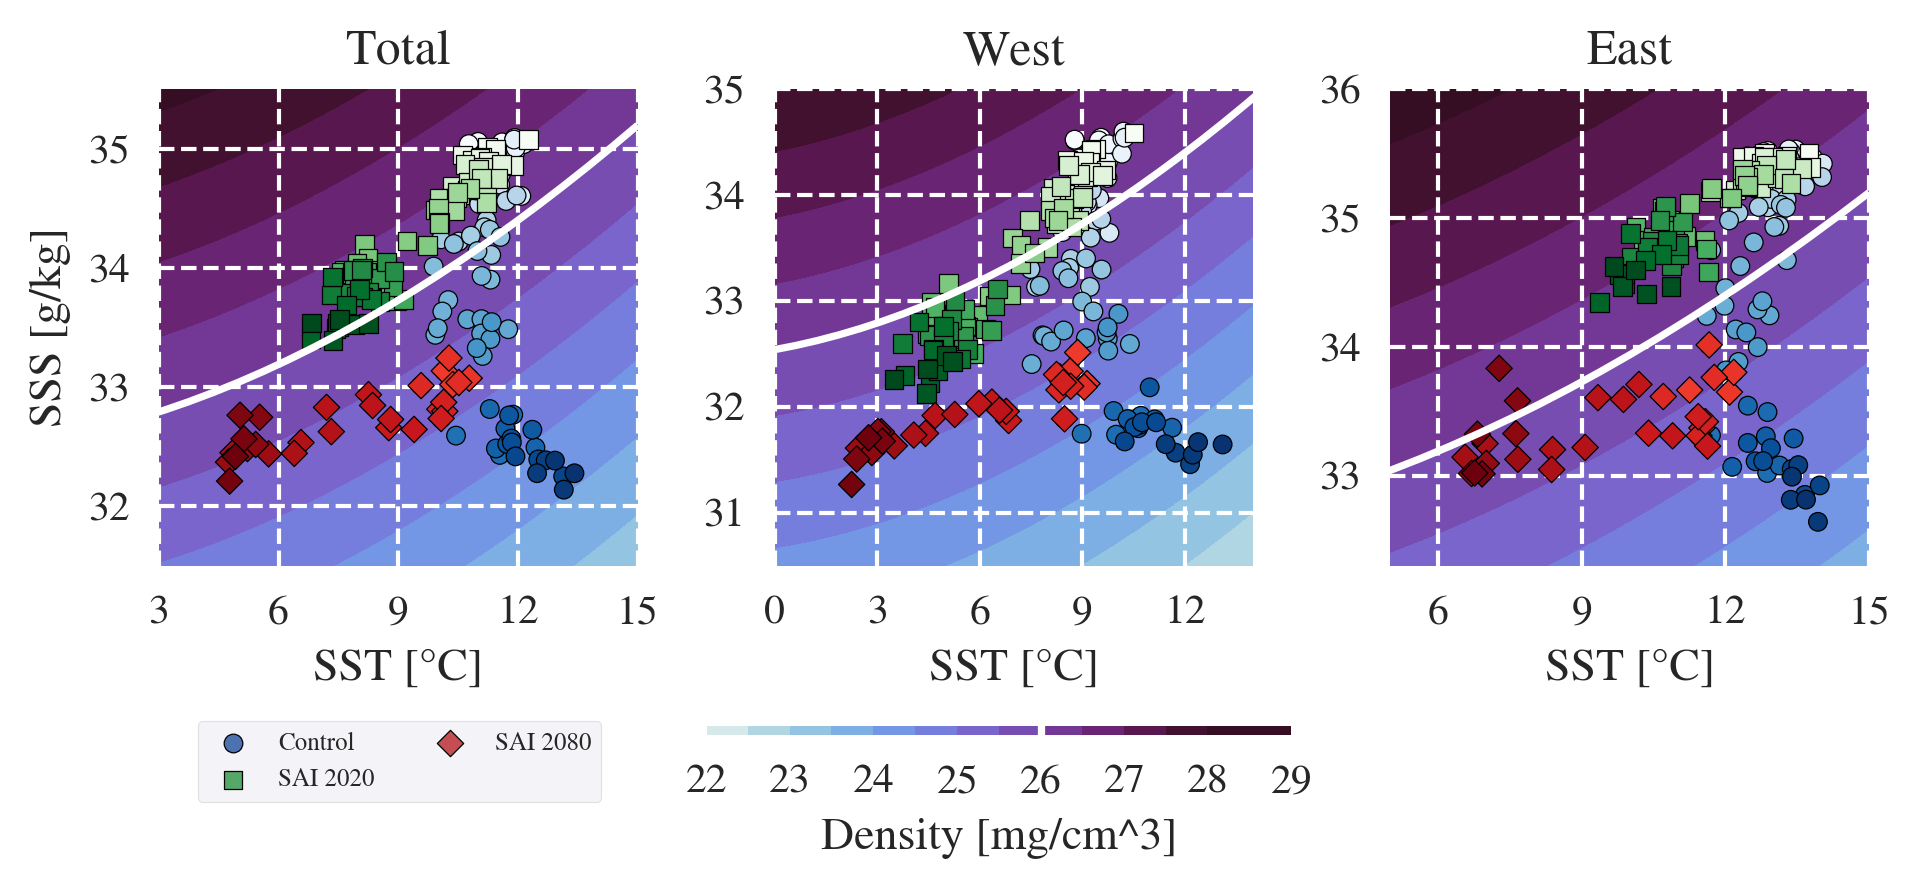

In [112]:
fig, axes = plt.subplots(ncols=3,figsize=(6.5,2.5),dpi=300)

temps = np.linspace(0,15,25)
salts = np.linspace(30.5,36,25)
temp_grid, salt_grid = np.meshgrid(temps,salts)
rho_grid = gsw.rho_t_exact(salt_grid,temp_grid,0)
dens_norm = matplotlib.colors.Normalize(vmin=22,vmax=28)
yr_norm = matplotlib.colors.Normalize(vmin=2020,vmax=2100)
marker_cmaps = ['Blues', 'Greens', 'Reds']
markers = ['o','s','D']
cfs = {}
for ax, rsuffix, rtitle in zip(axes,['','_west','_east'],['Total','West','East']):

    cfs[rtitle] = ax.contourf(temps,salts,rho_grid-1000,levels=12,cmap=cmocean.cm.dense,zorder=0,
                    norm=dens_norm)
    ax.contour(temps,salts,rho_grid-1000,levels=[26],colors='white')
    #ax.colorbar(cf)
    
    # select a certain month
    month_i = 9
    for name,m_cmap,m_style in zip(['Control','SAI 2020','SAI 2080'],marker_cmaps,markers):
        sss = sel_month(scenarios[name][f'sss{rsuffix}'],month_i)
        sst = sel_month(scenarios[name][f'sst{rsuffix}'],month_i)
        ts = sss.time.dt.year
        ax.scatter(sst,sss,edgecolors='black',label=name,
                  c=ts, norm=yr_norm, cmap=m_cmap,marker=m_style,s=20)
    
    ax.set_xlabel('SST [°C]')
    ax.set_ylabel('SSS [g/kg]')
    ax.set_title(rtitle)
    ax.xaxis.grid(True, zorder=5,color='white',linestyle='dashed')
    ax.yaxis.grid(True, zorder=5,color='white',linestyle='dashed')

for ax in axes[1:3]:
    ax.set_ylabel(None)
    
# set axis limits for all the plots individually
# (sss, sst ranges are different for the subregions)
axes[0].set_xlim([3,15])
axes[0].set_ylim([31.5,35.5])
axes[1].set_xlim([0,14])
axes[1].set_ylim([30.5,35])
axes[2].set_xlim([5,15])
axes[2].set_ylim([32.3,36])
for ax in axes:
    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    
fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.37, 0.0, 0.3, 0.012])
cbar_ax.axvline(x=26,color='white')
fig.colorbar(cfs['East'],
             cax=cbar_ax,orientation='horizontal',label='Density [mg/cm^3]')

axes[0].legend(fontsize=fsize_min,frameon=True,framealpha=0.5,edgecolor=None,ncol=2,
              bbox_to_anchor=(0.95, -0.3))
scatter_legend = axes[0].get_legend()
colors = ['C0','C1','C2']
for color, legendHandle in zip(colors,scatter_legend.legendHandles):
    legendHandle.set_color(color)
    legendHandle.set_edgecolor('black')

plt.tight_layout()

In [114]:
fig.savefig('./gfx/sfig_sss_sst_trajectories.pdf',bbox_inches='tight')

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
